For every row in a dataframe, calculate
```python
percentileofscore(df[(df['d'] > row['d']-interval) & (df['d'] < row['d']+interval)], row['a'])
```

In [31]:
import pandas as pd
import numpy as np
from scipy.stats import percentileofscore
from tqdm import tqdm
from time import time
tqdm.pandas()
%matplotlib inline

In [54]:
df_original = pd.DataFrame(np.random.randint(0,100,size=(20000,2)), columns=['D', 'R'])

In [55]:
df_original.head()

,D,R
0,51,94
1,80,37
2,53,32
3,86,86
4,23,95


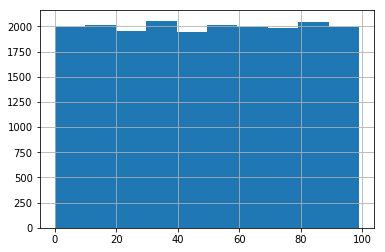

In [56]:
df_original['D'].hist()

# Method 1: Use between

In [57]:
def score(duration, ratio, df, interval):
    a = df[df['R'].between(duration-interval,duration+interval)]['D'].values
    return percentileofscore(a, ratio)
def method1():
    df = df_original.copy(deep=True)
    # df = df.sort_values(by='D')
    df['rank_1'] = df.apply(lambda row: score(row['D'], row['R'], df, 1), axis=1)

# Method 2: Use built in bisect and an implementation of a reverse bisect (requires presorting)

In [58]:
import bisect

def rev_bisect(l, v):
    '''l -> list (descending order)
       v -> value
    Returns:
       int -> position to insert value in list keeping it sorted
    '''
    h = list(range(len(l))) + [len(l)+1]
    h.reverse()
    l.reverse()
    return h[bisect.bisect_left(l, v)]


def compute_percentile(duration, ratio, interval, df, duration_list, duration_list_rev):
    upper = duration + interval
    lower = duration - interval
    
    idx_lower = bisect.bisect(duration_list, lower)
    idx_upper = rev_bisect(duration_list_rev, upper)
    
    array = df['R'].iloc[idx_lower:idx_upper]
    
    return percentileofscore(array, ratio)

def method2():
    df = df_original.copy(deep=True)
    df_sort = df.sort_values(by='D').reset_index(drop=True)
    df_rev_sort = df.sort_values(by='D', ascending=False).reset_index(drop=True)
    duration_list = list(df_sort['D'])
    duration_list_rev = list(df_rev_sort['D'])

    df['rank_2'] = df.apply(lambda row: compute_percentile(row['D'], row['R'], 1, df_sort, duration_list, duration_list_rev), axis=1)

# Method 3: Use searchsorted(bisect) (requires presorting)

In [59]:
def compute_percentile2(duration, ratio, interval, df, duration_list):
    upper = np.uint32(duration + interval)
    lower = np.uint32(duration - interval)
    
    idx_lower = np.searchsorted(duration_list, lower)
    idx_upper = np.searchsorted(duration_list, upper)
    
    array = df[idx_lower:idx_upper]
    
    return percentileofscore(array, ratio)
def method3():
    df = df_original.copy(deep=True)
    df_sort = df.sort_values(by='D').reset_index(drop=True)
    duration_list = np.asarray(list(df_sort['D']))

    df['rank_3'] = df.apply(lambda row: compute_percentile2(row['D'], row['R'], 1, df_sort['R'].values, duration_list), axis=1)

In [ ]:
from statistics import median
method_1 = []
method_2 = []
method_3 = []
for i in range(3):
    start = time()
    method1()
    method_1.append(time()-start)
for i in range(3):
    start = time()
    method2()
    method_2.append(time()-start)
for i in range(3):
    start = time()
    method3()
    method_3.append(time()-start)
print('Median runtime for Method 1: {}'.format(median(method_1)))
print('Median runtime for Method 2: {}'.format(median(method_2)))
print('Median runtime for Method 3: {}'.format(median(method_3)))

In [53]:
import math
math.sqrt(10.45)

3.2326459750489227